In [16]:
CMAP = "Blues"

# Water Product Interoperability  


TODO

### Current Water products  

Interoperability is explored across three derived water products from `Sentinel 1`, `Sentinel 2` and `Landsat 8`. The classification and initial data-exploration is conducted in separate notebooks listed below: 

   - `Sentinel 1`- [link]()    
   A thresholding algorthim takes advantage of linear class separability on vv and vh bands to classify water.  
     
     
   - `Landsat 8`- [link]()    
   The Water Observations From Space(WOFS) algorithm is applied to Landsat8 imagery. WOFS uses a decision tree on surface reflectance features.    
   
   
   - `Sentinel 2`- [link]()    
   The Water Observations From Space(WOFS) algorithm is applied to Sentinel 2 imagery. While the original WOFS algorithm was trained and calibrated on Landsat 7 imagery, relatively consistent results are expected from a re-application on Sentinel 2 imagery and are tolerated for the purpose of exploring interoperability.     
   
The outputs of these notebooks are temporarily saved into corressponding `netcdf` files. To properly run this notebook. Ensure that the notebooks listed above have been run.  


### Loading Water Products  

The following code lists the paths for three water products and loads them into the notebook.  

In [2]:
from pathlib import Path
# Define dataset file paths
DATA_DIR = Path('output/netcdfs')
DATASETS = {
    'l8': DATA_DIR / 'landsat8_nbar' / 'water_classify.nc',
    's1': DATA_DIR / 'sentinel_1_gamma' / 'water_classify2.nc',
    's2': DATA_DIR / 'sentinel_2_ab' / 'water_classify.nc'
}

In [4]:
import xarray as xr 
# Load datasets
datasets = {name: xr.open_dataset(path) for name, path in DATASETS.items()}
print('Loaded datasets: {}'.format(', '.join(datasets.keys())))

Loaded datasets: l8, s1, s2


In [5]:
import functools as fct
merged = fct.reduce(lambda ds_a, ds_b: ds_a.merge(ds_b), datasets.values())

### Areas of Investigation and Measures of Interoperability

- **Availability**
- **Variability**
- **Visual Interpretability**


Each xarray contains a variable called `wofs` that houses water classifications from the classifiers. Values in these xarray assume one of three values. `1`,`0` for water and not-water as well as `nan` values for areas occluded by cloud or are missing data.  

# Lake George

In [69]:
latitudes = (-35.217575569215505, -34.97543887925878) 
longitudes = (149.2719268798828, 149.5095062255859)

In [72]:
display_map(latitude = latitudes, longitude = longitudes)

### An annual extent derived from merged products

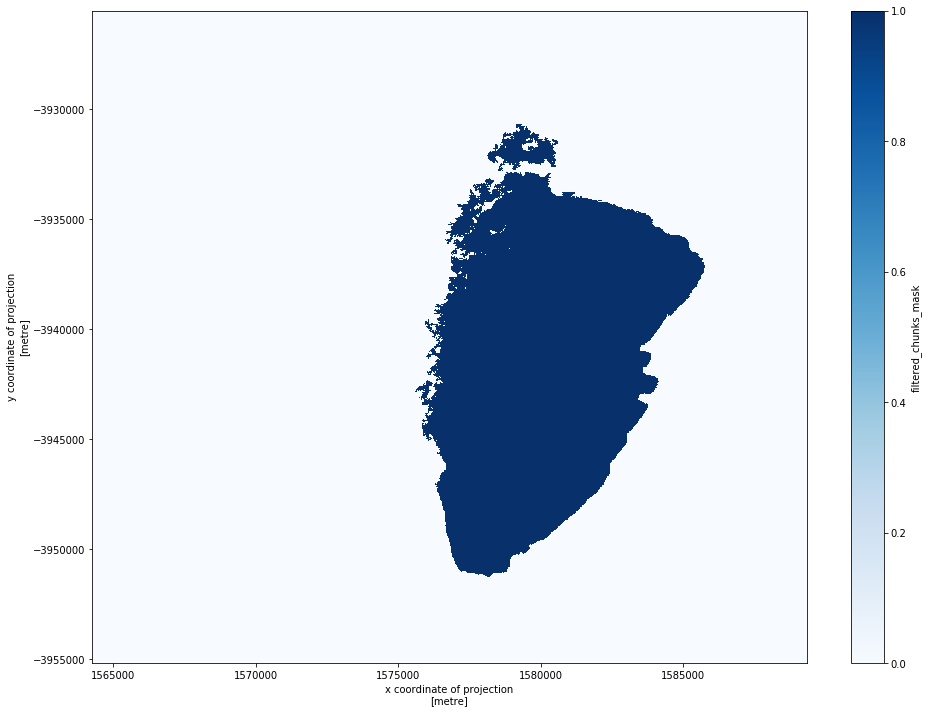

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (16,12))
extract_large_body_from_boolean_xarray(merged.wofs).plot(cmap = CMAP)

# Annual Summary Products  

Something about annual summary products. 

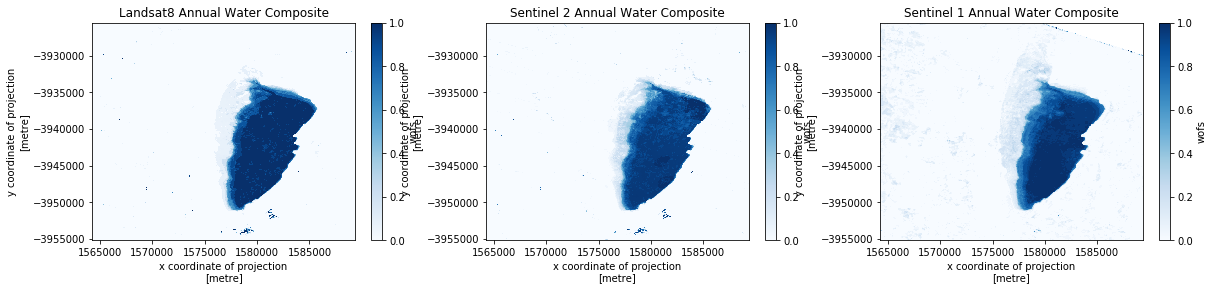

In [54]:
fig, axes = plt.subplots(1,3, figsize = (20,4))

a = datasets["l8"].mean(dim = "time", skipna = True).wofs
b = datasets["s2"].mean(dim = "time", skipna = True).wofs
c = datasets["s1"].mean(dim = "time", skipna = True).wofs

a.plot(ax=axes[0], cmap = CMAP)
axes[0].set_title("Landsat8 Annual Water Composite")

b.plot(ax=axes[1], cmap = CMAP)
axes[1].set_title("Sentinel 2 Annual Water Composite")

c.plot(ax=axes[2], cmap = CMAP)
axes[2].set_title("Sentinel 1 Annual Water Composite")

plt.show()

In [80]:
plot_availability(datasets)

In [95]:
create_movie_on_np_array(datasets["l8"].wofs.values, text = [*map(str, datasets["l8"].wofs.time.values)])

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [56]:
import folium
import itertools    
import math
import numpy as np  

def _degree_to_zoom_level(l1, l2, margin = 0.0):
    
    degree = abs(l1 - l2) * (1 + margin)
    zoom_level_int = 0
    if degree != 0:
        zoom_level_float = math.log(360/degree)/math.log(2)
        zoom_level_int = int(zoom_level_float)
    else:
        zoom_level_int = 18
    return zoom_level_int

def display_map(latitude = None, longitude = None, resolution = None):
    """ Generates a folium map with a lat-lon bounded rectangle drawn on it. Folium maps can be 
    
    Args:
        latitude   (float,float): a tuple of latitude bounds in (min,max) format
        longitude  ((float, float)): a tuple of longitude bounds in (min,max) format
        resolution ((float, float)): tuple in (lat,lon) format used to draw a grid on your map. Values denote   
                                     spacing of latitude and longitude lines.  Gridding starts at top left 
                                     corner. Default displays no grid at all.  
    Returns:
        folium.Map: A map centered on the lat lon bounds. A rectangle is drawn on this map detailing the
        perimeter of the lat,lon bounds.  A zoom level is calculated such that the resulting viewport is the
        closest it can possibly get to the centered bounding rectangle without clipping it. An 
        optional grid can be overlaid with primitive interpolation.  
    .. _Folium
        https://github.com/python-visualization/folium
    """
    
    assert latitude is not None
    assert longitude is not None

    ###### ###### ######   CALC ZOOM LEVEL     ###### ###### ######

    margin = -0.5
    zoom_bias = 0
    
    lat_zoom_level = _degree_to_zoom_level(margin = margin, *latitude ) + zoom_bias
    lon_zoom_level = _degree_to_zoom_level(margin = margin, *longitude) + zoom_bias
    zoom_level = min(lat_zoom_level, lon_zoom_level) 

    ###### ###### ######   CENTER POINT        ###### ###### ######
    
    center = [np.mean(latitude), np.mean(longitude)]

    ###### ###### ######   CREATE MAP         ###### ###### ######
    
    map_hybrid = folium.Map(
        location=center,
        zoom_start=zoom_level, 
        tiles=" http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google"
    )
    
    ###### ###### ######     BOUNDING BOX     ###### ###### ######
    
    line_segments = [(latitude[0],longitude[0]),
                     (latitude[0],longitude[1]),
                     (latitude[1],longitude[1]),
                     (latitude[1],longitude[0]),
                     (latitude[0],longitude[0])
                    ]
    
    
    
    map_hybrid.add_child(
        folium.features.PolyLine(
            locations=line_segments,
            color='red',
            opacity=0.8)
    )

    map_hybrid.add_child(folium.features.LatLngPopup())        

    return map_hybrid

In [57]:
from skimage import measure
import numpy as np

def group_pixels(array, connectivity = 1):
    arr = measure.label(array, connectivity=connectivity)
    return [np.dstack(np.where(arr == y))[0] for y in range(1,np.amax(arr))]

def numpy_group_mask(boolean_np_array, min_size = 5):  
    all_groups = group_pixels(boolean_np_array.astype(int))
    candidate_groups = filter(lambda group:
                                  (len(group) > min_size) & (group != 0).all(),
                                  all_groups)
    candidate_pixels = (pixel for group in candidate_groups for pixel in group)  
    dynamic_array = np.zeros(boolean_np_array.shape) 
    for x,y in candidate_pixels:
        dynamic_array[x][y] = 1  
    return dynamic_array.astype(bool)


def boolean_xarray_segmentation_filter(da,  min_size = 5):
    mask_np = numpy_group_mask(da.values,min_size = min_size)
    return xr.DataArray(mask_np,
                        dims = da.dims,
                        coords = da.coords,
                        attrs = {"group_size": min_size},
                        name = "filtered_chunks_mask")


In [58]:
def extract_large_body_from_boolean_xarray( da:xr.DataArray,
                                            frequency_percentile:float = 0.0625,
                                            min_number_of_pixels:int = 1000):

    body = (da.mean(dim = "time") > frequency_percentile)
    return boolean_xarray_segmentation_filter(body, min_size= min_number_of_pixels)
    

# Availability

In [59]:
from calendar import month_name
import numpy as np
import xarray as xr
from pathlib import Path
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.core.properties import value
from bokeh.transform import dodge
from bokeh.models import Label
from bokeh.palettes import Accent6, Dark2, Category10
from bokeh.colors.named import darkgray

In [60]:
output_notebook()

Loading BokehJS ...

**Acquisition Count Per Month**

In [61]:
# Calculate frequencies per months. Months with no data are handled by combining with
# an empty `all_months` data array. 
coords={'month': range(1, 13)}
months_str = [m[:3] for m in list(month_name)[1:]]
frequencies = {}
for name, dataset in datasets.items():
    freq = dataset.time.groupby('time.month').count('time')
    all_months = xr.DataArray(data = [0]*12, coords=coords, dims=coords, name='time')
    frequencies[name] = freq.combine_first(all_months).assign_coords(month=months_str)

In [62]:
# Calculate the aggregated value for each month
aggregated = np.sum([freq.values for freq in frequencies.values()], axis=0)
aggregated

array([ 5,  8,  7,  8,  7,  6, 11,  9, 11,  9, 10, 11])

In [63]:
# Generate the bar chart on a new figure
data = {name: freq.values for name, freq in frequencies.items()}
data['months'] = months_str
data['aggregated'] = aggregated

# Calculate the max frequency to scale the Y-axis automatically
max_freq = max([freq.values.max() for freq in frequencies.values()] + [aggregated.max()])

p = figure(x_range=months_str,
           y_range=(0, max_freq),
           plot_width=800,
           plot_height=400,
           title="Monthly data points",
           toolbar_location=None,
           tools="")

# Calculate offsets and widths for the bars
inter_group = 0.4
width = (1 - inter_group / 2) / len(frequencies)
offset = (width + inter_group / 2 - 1) / 2

# Plot the aggregate bar
p.vbar(x=dodge('months', 0, range=p.x_range), 
       top='aggregated', 
       width=(1 - inter_group + width / 2), 
       source=data,
       color='#000000', 
       legend=value('aggregated'), 
       fill_alpha=0, 
       line_color='lightgray', 
       line_width=2.0)

# Plot the raw data bars, one per dataset
for count, name in enumerate(frequencies.keys()):
    p.vbar(x=dodge('months', count*width+offset, range=p.x_range), 
           top=name, 
           width=width-0.1, 
           source=data,
           color=Category10[10][count],
           legend=value(name), 
           fill_alpha=.4)
    
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
show(p)

In [64]:
import matplotlib.pyplot as plt  
from functools import reduce
merged_product = reduce(lambda dsa, dsb: dsa.merge(dsb), datasets.values()) 

In [65]:
plt.figure(figsize = (10,8))
lake_george = (merged_product.wofs.mean(dim = "time") > .0625)

<Figure size 720x576 with 0 Axes>

In [66]:
from skimage import measure
import numpy as np

def group_pixels(array, connectivity = 1):
    arr = measure.label(array, connectivity=connectivity)
    return [np.dstack(np.where(arr == y))[0] for y in range(1,np.amax(arr))]

def numpy_group_mask(boolean_np_array, min_size = 5):  
    all_groups = group_pixels(boolean_np_array.astype(int))
    candidate_groups = filter(lambda group:
                                  (len(group) > min_size) & (group != 0).all(),
                                  all_groups)
    candidate_pixels = (pixel for group in candidate_groups for pixel in group)  
    dynamic_array = np.zeros(boolean_np_array.shape) 
    for x,y in candidate_pixels:
        dynamic_array[x][y] = 1  
    return dynamic_array.astype(bool)


def boolean_xarray_segmentation_filter(da,  min_size = 5):
    mask_np = numpy_group_mask(da.values,min_size = min_size)
    return xr.DataArray(mask_np,
                        dims = da.dims,
                        coords = da.coords,
                        attrs = {"group_size": min_size},
                        name = "filtered_chunks_mask")


In [45]:
def meter_to_pixel(meter:int, resolution = None) -> int:
    return meter/resolution

In [55]:
lake_george = (merged_product.wofs.mean(dim = "time") > .0625)

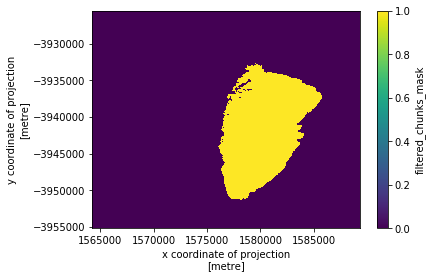

In [56]:
lake_george = (merged_product.wofs.mean(dim = "time") > .0625)
boolean_xarray_segmentation_filter(lake_george, min_size= 1000)
boolean_xarray_segmentation_filter(lake_george, min_size= 1000).plot()

In [94]:
from IPython.display import HTML, display, Image
from tempfile import NamedTemporaryFile
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation as animation
from skimage.transform import resize as imresize
%matplotlib inline

def create_movie_on_np_array(frames,
                 title = "foo \n test",
                 text=None,
                 fps=5,
                 width=10,
                 height=5,
                 align=True,
                 alphas=None):
    
    
    if text is None:
        text = ['' for s in range(len(frames))]
    ref_shape = frames[0].shape
    fig, ax = plt.subplots()
    ax.set_title = "Title" + "\n" + text[0]
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    im = ax.imshow(frames[0], cmap = CMAP)
    _text = ax.text(20, 100, text[0], fontsize=14, color='white')
    im.set_clim([0,1])
    fig.set_size_inches([width,height])
    plt.tight_layout()
    
    def update_img(n):
        frame = imresize(frames[n], ref_shape, order=3)
    
        ax.set_title = "Title" + "\n" + text[n]
        _text.set_text(text[n])
        im.set_data(frame)
        return im,
    
    def init():
        im.set_data(frames[0])
        return im,
       
    anim = animation.FuncAnimation(fig, update_img, len(frames), init_func=init, interval=1000);
        
    plt.close(anim._fig)
    return display(HTML(anim.to_jshtml()));

In [79]:
from typing import Dict
def plot_availability(data: Dict[str, xr.Dataset]):
    # Generate the bar chart on a new figure
    data = {name: freq.values for name, freq in frequencies.items()}
    data['months'] = months_str
    data['aggregated'] = aggregated

    # Calculate the max frequency to scale the Y-axis automatically
    max_freq = max([freq.values.max() for freq in frequencies.values()] + [aggregated.max()])

    p = figure(x_range=months_str,
               y_range=(0, max_freq),
               plot_width=800,
               plot_height=400,
               title="Monthly data points",
               toolbar_location=None,
               tools="")

    # Calculate offsets and widths for the bars
    inter_group = 0.4
    width = (1 - inter_group / 2) / len(frequencies)
    offset = (width + inter_group / 2 - 1) / 2

    # Plot the aggregate bar
    p.vbar(x=dodge('months', 0, range=p.x_range), 
           top='aggregated', 
           width=(1 - inter_group + width / 2), 
           source=data,
           color='#000000', 
           legend=value('aggregated'), 
           fill_alpha=0, 
           line_color='lightgray', 
           line_width=2.0)

    # Plot the raw data bars, one per dataset
    for count, name in enumerate(frequencies.keys()):
        p.vbar(x=dodge('months', count*width+offset, range=p.x_range), 
               top=name, 
               width=width-0.1, 
               source=data,
               color=Category10[10][count],
               legend=value(name), 
               fill_alpha=.4)

    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.legend.location = "top_left"
    p.legend.orientation = "horizontal"
    show(p)